In [1]:
from fastai.text import *
from fastai.callbacks import *

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import AdamW

from tqdm.notebook import tqdm

In [2]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed_value)

seed = 777
seed_all(seed)

In [3]:
def reduce_mem_usage(df):
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type == object:
            df[col] = df[col].astype('category')
        else:
            c_min = df[col].min()
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [4]:
train_df = pd.read_csv('./train.csv')
train_df = reduce_mem_usage(train_df)
train_df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893555,haha you guys are a bunch of losers.,0.021271,0.0,0.021271,0.872559,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens
    
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [6]:
use_fp16 = False
bs = 32

transformer_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = 'roberta')
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [7]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [8]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
print(transformer_tokenizer.convert_ids_to_tokens(ids))

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]
['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']


In [9]:
pad_first = False # except for XLNet
pad_idx = transformer_tokenizer.pad_token_id

databunch = (TextList.from_df(train_df, cols='comment_text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'target')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [10]:
databunch.show_batch()

text,target
"<s> Ġ"" ðĿ Ļ ı ðĿ Ļ Ŀ ðĿ Ļ ļ Ġ ðĿ Ļ Ĺ ðĿ Ļ ŀ ðĿ Ļ ľ Ġ ðĿ Ļ ¥ ðĿ Ļ § ðĿ Ļ ¤ ðĿ Ļ Ĺ ðĿ Ļ ¡ ðĿ Ļ ļ ðĿ Ļ ¢ Ġ ðĿ Ļ ŀ ðĿ Ļ ¨ Ġ ðĿ Ļ ĸ ðĿ Ļ ¡ ðĿ Ļ ¡ ðĿ Ļ ĸ ðĿ Ļ ® ðĿ Ļ ŀ ðĿ",0.0
<s> ĠA : Ġ($ 10 . 36 Ġmil Ġ( U AA ĠAthletics )) Ġ/ Ġ($ 377 Ġmil Ġ( UA ĠBudget )) Ġ= Ġ2 . 7 %. Ġ Ċ Maybe Ġyou Ġshould Ġgo Ġback Ġto Ġschool . Ċ Ċ B : ĠHere Ġare Ġmy Ġschool Ġfees . Ċ Ċ - Sch Ġof ĠBus Ġ1 ĠTime ĠSem ester ĠLab ĉ $ 34 . 00 Ċ - A th let ic / Rec,0.0
"<s> ĠLet 's Ġsee . ĠWe Ġneed Ġfunding Ġfor Ġthe Ġport . ĠLike , ĠNow . ĠHow Ġabout Ġthese : Ċ Close Ġthe ĠSp en ard ĠL IO , Ġsell Ġit Ġoff Ġfor Ġat Ġleast Ġ$ 10 Ġmillion . ĠWe 'll Ġlose Ġ$ 2 Ġmillion , Ġbut Ġit 's Ġa Ġquicker Ġsale Ġand Ġwe Ġcan Ġpenal ize Ġour Ġso - called Ġ' rep rest atives ' Ġover Ġ10 Ġyears Ġto",0.19995117
"<s> ĠWhen ĠI Ġfirst Ġread Ġabout Ġthe ĠKh adr Ġsettlement Ġyesterday , Ġthe Ġfirst Ġthing Ġthat Ġimmediately Ġcame Ġto Ġmind Ġwas Ġa Ġscene Ġfrom Ġthe Ġexcellent , Ġunderrated Ġ90 s Ġflick , ĠA ĠBronx ĠTale . Ċ In Ġit , Ġthe Ġlocal Ġmafia Ġboss , ĠSonny Ġ( Ch azz ĠPal min ter i ) Ġwatches Ġas ĠCal og ero Ġ( a . k . a ."" C ,"" Ġplayed Ġby",0.0
"<s> ĠTerr ified Ġby ĠTrump 's Ġwords Ġand Ġactions Ġand Ġthose Ġof Ġsome Ġof Ġhis Ġsupporters , Ġeh ? Ġ ĠWhat Ġabout Ġthe Ġwords Ġand Ġactions Ġof Ġthose Ġwho Ġclearly Ġdidn 't Ġsupport ĠTrump ? Ġ Ġ Ċ Ċ http :// w reg . com / 2016 / 12 / 21 / miss iss ippi - author ities - make - ar rest - in - burning - of -",0.0


In [11]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):        
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [13]:
config = RobertaConfig.from_pretrained('roberta-base')
config.num_labels = 1
config.use_bfloat16 = use_fp16
print(config) 

{
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [14]:
transformer_model = RobertaForSequenceClassification.from_pretrained('roberta-base', config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [15]:
CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

learner.callbacks.append(ShowGraph(learner))

if use_fp16: 
    learner = learner.to_fp16()

In [16]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

learner.split(list_layers)
num_groups = len(learner.layer_groups)

epoch,train_loss,valid_loss,accuracy,error_rate,time


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.98E-05


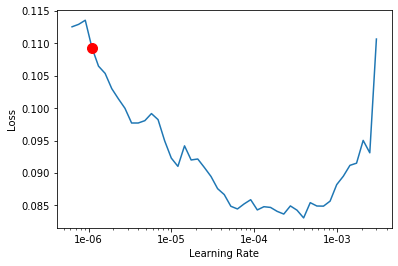

In [17]:
learner.freeze_to(-1)
learner.lr_find()
learner.recorder.plot(suggestion=True)

Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.98E-05


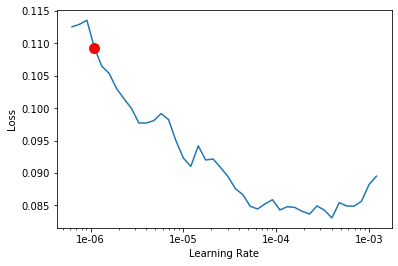

In [18]:
learner.recorder.plot(skip_end=10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.029445,0.029365,0.700710,0.299290,1:02:54


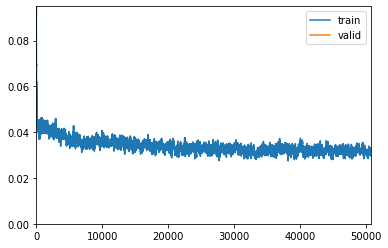

In [19]:
learner.fit_one_cycle(1,max_lr=4e-05,moms=(0.8,0.7))
learner.save('stage_1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.018591,0.016612,0.700710,0.299290,1:23:45


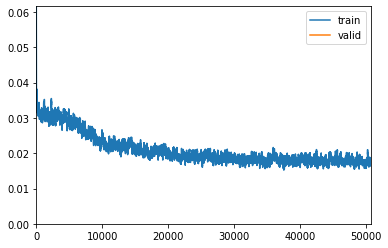

In [20]:
learner.freeze_to(-2)
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('stage_2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.016986,0.014818,0.700710,0.299290,1:34:03


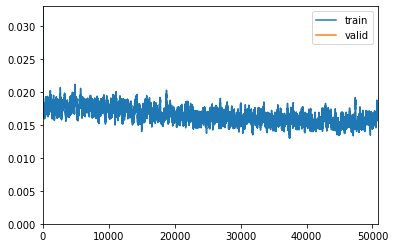

In [21]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('stage_3')

In [22]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.save('stage_4')

epoch,train_loss,valid_loss,accuracy,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 10.76 GiB total capacity; 9.81 GiB already allocated; 56.12 MiB free; 9.94 GiB reserved in total by PyTorch)